# COZZZY Проект

Исполнители: Андрей Шумилин, Илья Шамшединов, Всеволод Шурыгин и Ткалич Леонид

[Ссылка на наш супер cozy github](https://github.com/seemsGoodNow/XxxPRAvCmLIVAxxX/tree/master)

## Источники

- https://www.moex.com/ru/factsheet/history - RUSFAR (базовые данные для оценки CIR c 2019) и MOEXREPO (для оценки пуассоновских скачков на кризисных 2014-2015)
- https://fred.stlouisfed.org/series/SOFR - SOFR ставка по доллару (c 2019)
- https://www.moex.com/ru/derivatives/currency-rate.aspx?currency=USD_RUB# - курс FX (c 2019)

# Загрузка данных

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import xmltodict, json
from simulation import DefaultCIR, ConstPossionJumpsCIR, NormalPossionJumpsCIR
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Image

https://www.moex.com/ru/factsheet/history

In [3]:
rusfar = pd.read_csv('data/RUSFAR_2019-01-01__2024-01-01.csv', delimiter=';')
rusfar = rusfar.drop(columns=['ID', 'NAME', 'OPEN', 'HIGH', 'LOW', 'VALUE', 'DURATION', 'YIELD'])
rusfar = rusfar.rename(columns={'TRADEDATE': 'date', 'CLOSE': 'rub_rate'})
rusfar['rub_rate'] = rusfar['rub_rate'].str.replace(',', '.').astype(float)
rusfar['date'] = pd.to_datetime(rusfar['date'])
rusfar = rusfar.sort_values('date').set_index('date')
rusfar.head(2)

rub_rate
date                
2019-01-09      7.71
2019-01-10      7.68

**Возьмем еще оттуда ставку репо MOEXREPO для оценки на кризисных периодах**

In [4]:
repo = pd.read_csv('data/test.csv', delimiter=';')[['TRADEDATE', 'CLOSE']]
repo = repo.rename(columns={'TRADEDATE': 'date', 'CLOSE': 'rub_repo_rate'})
repo['date'] = pd.to_datetime(repo['date'])
# Оставим кризисный год с 01.10.2014 по 2015
repo = repo[
    (repo['date'] >= pd.Timestamp('2014-10-01'))
    & (repo['date'] < pd.Timestamp('2015-10-01'))
]
repo = repo.sort_values('date').set_index('date')
repo.head(2)

rub_repo_rate
date                     
2014-10-01           7.93
2014-10-02           7.96

https://fred.stlouisfed.org/series/SOFR

In [5]:
sofr = pd.read_csv('data/SOFR_2019-01-01__2024-01-01.csv')
sofr = sofr.rename(columns={'DATE': 'date', 'SOFR': 'usd_rate'})
sofr = sofr[sofr['usd_rate'] != '.'] # strange value at the end
sofr['usd_rate'] = sofr['usd_rate'].astype(float)
sofr['date'] = pd.to_datetime(sofr['date'])
sofr = sofr.sort_values('date').set_index('date')
sofr.head(2)

usd_rate
date                
2019-01-02      3.15
2019-01-03      2.70

https://www.moex.com/ru/derivatives/currency-rate.aspx?currency=USD_RUB#

In [6]:
with open('data/USD_RUB_2019-01-01__2024-01-01.xml', 'r') as f:
    usdrub = pd.DataFrame(xmltodict.parse(f.read())['document']['data']['rows']['row'])
# there are 2 values (morning and evening) per day, remain only evening
usdrub = usdrub[usdrub['@clearing']=='vk'].drop(columns=['@tradetime', '@secid', '@clearing'])
usdrub = usdrub.rename(columns={'@tradedate': 'date', '@rate': 'fx'})
usdrub['fx'] = usdrub['fx'].astype(float)
usdrub['date'] = pd.to_datetime(usdrub['date'])
usdrub = usdrub.sort_values('date').set_index('date')
usdrub.head(2)

fx
date               
2019-01-03  68.8620
2019-01-04  67.8181

In [7]:
data = pd.concat([
    rusfar, sofr, usdrub
], axis=1).bfill().ffill() # Протягиваем значение на случай пропуска
data.head()

rub_rate  usd_rate       fx
date                                   
2019-01-02      7.71      3.15  68.8620
2019-01-03      7.71      2.70  68.8620
2019-01-04      7.71      2.45  67.8181
2019-01-07      7.71      2.41  66.9909
2019-01-08      7.71      2.42  66.9909

# Изображения симуляций траекторий

## Ставка по USD с помощью дефолтной CIR

CIR модель задается как:

$$dr_t = \alpha(\theta - r_t)dt + \sigma \sqrt{r_t}dW_t,$$

где $\alpha$ - скорость возврата к среднему $\theta$, $\sigma$ - волатильность и мера, отвечающая за величину случайности

Использование схемы Эйлера-Муроямы позволяет получит следующее уравнение


$r_{t+dt} = r_t + \alpha(\theta - r_t)dt + \sigma \sqrt{r_t} (W_{t+dt} - W_{t})$

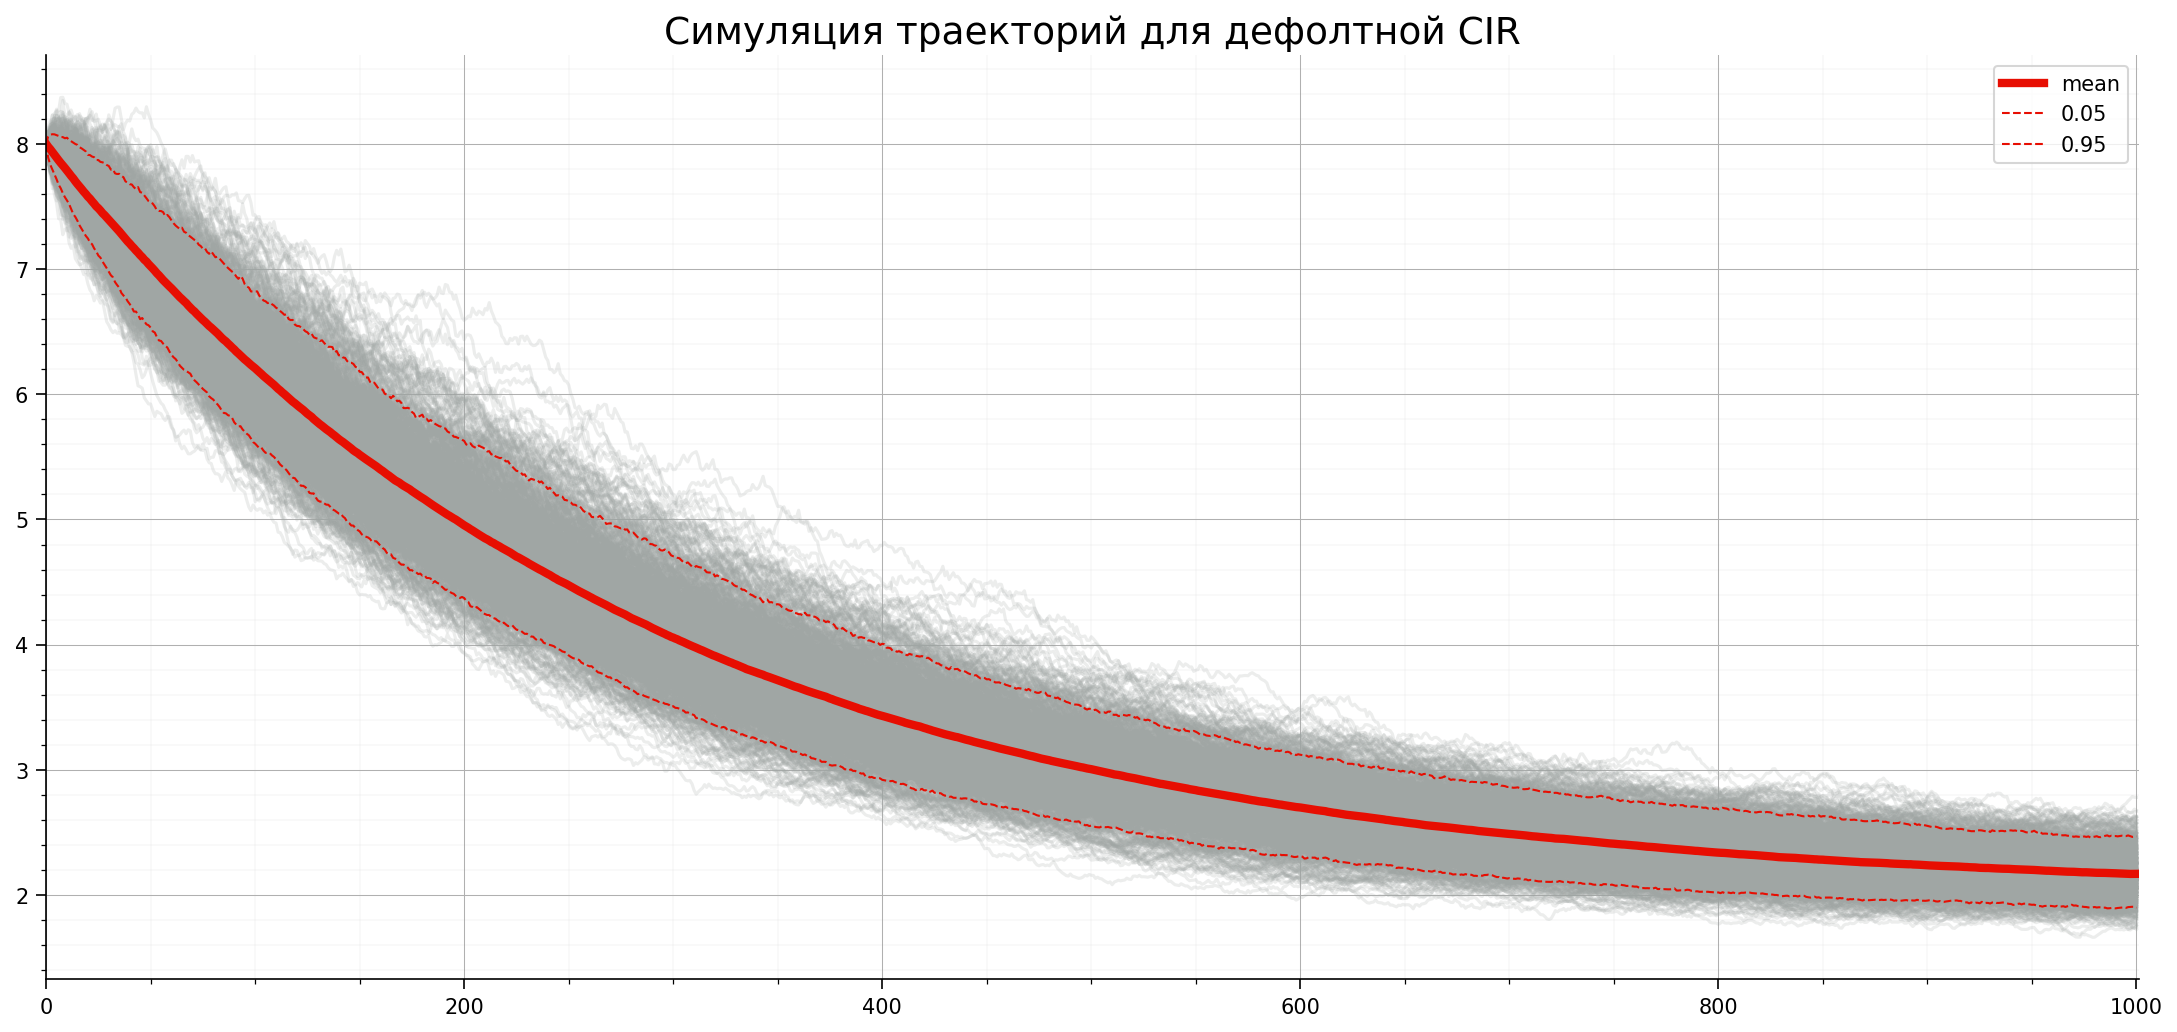

In [8]:
# Задаем какие-то параметры, которые нам нравятся (и которые мы хотим!)
alpha = 0.9
theta = 2
sigma = 0.1 # пошумим

n_steps = 1000 # 4 года
n_paths = 1000 # число путей для симуляции
dt = 1 / 252 # считаем, что в год у нас 252 дня идут торги, обоснование есть в блоке с rangeaccrual
r0 = 8 # начальное значение ставки

cir = DefaultCIR(
    alpha=alpha, 
    theta=theta, 
    sigma=sigma,
)
cir_paths = cir.get_simulated_paths(
    n_steps=n_steps, n_paths=n_paths, dt=dt, r0=r0
)
ax = cir.plot_paths(cir_paths)
ax.set_title('Симуляция траекторий для дефолтной CIR', fontsize=18)
plt.show()

## Ставка по RUB с помощью CIR и прыжков определенного размера 

CIR модель c Пуассоновскими прыжками постоянного размера задается как:

$dr_t = \alpha(\theta - r_t)dt + \sigma \sqrt{r_t}dW_t + JdN_t$

где $\alpha$ - скорость возврата к среднему $\theta$, $\sigma$ - волатильность и мера, отвечающая за величину случайности, $J$ - постоянный размер Пуассоновского прыжка, $dN_t$ - интенсивность прыжков.

Использование схемы Эйлера-Муроямы позволяет получит следующее уравнение


$r_{t+dt} = r_t + \alpha(\theta - r_t)dt + \sigma \sqrt{r_t} (W_{t+dt} - W_{t}) + J(N_{t+dt} + N_t)$

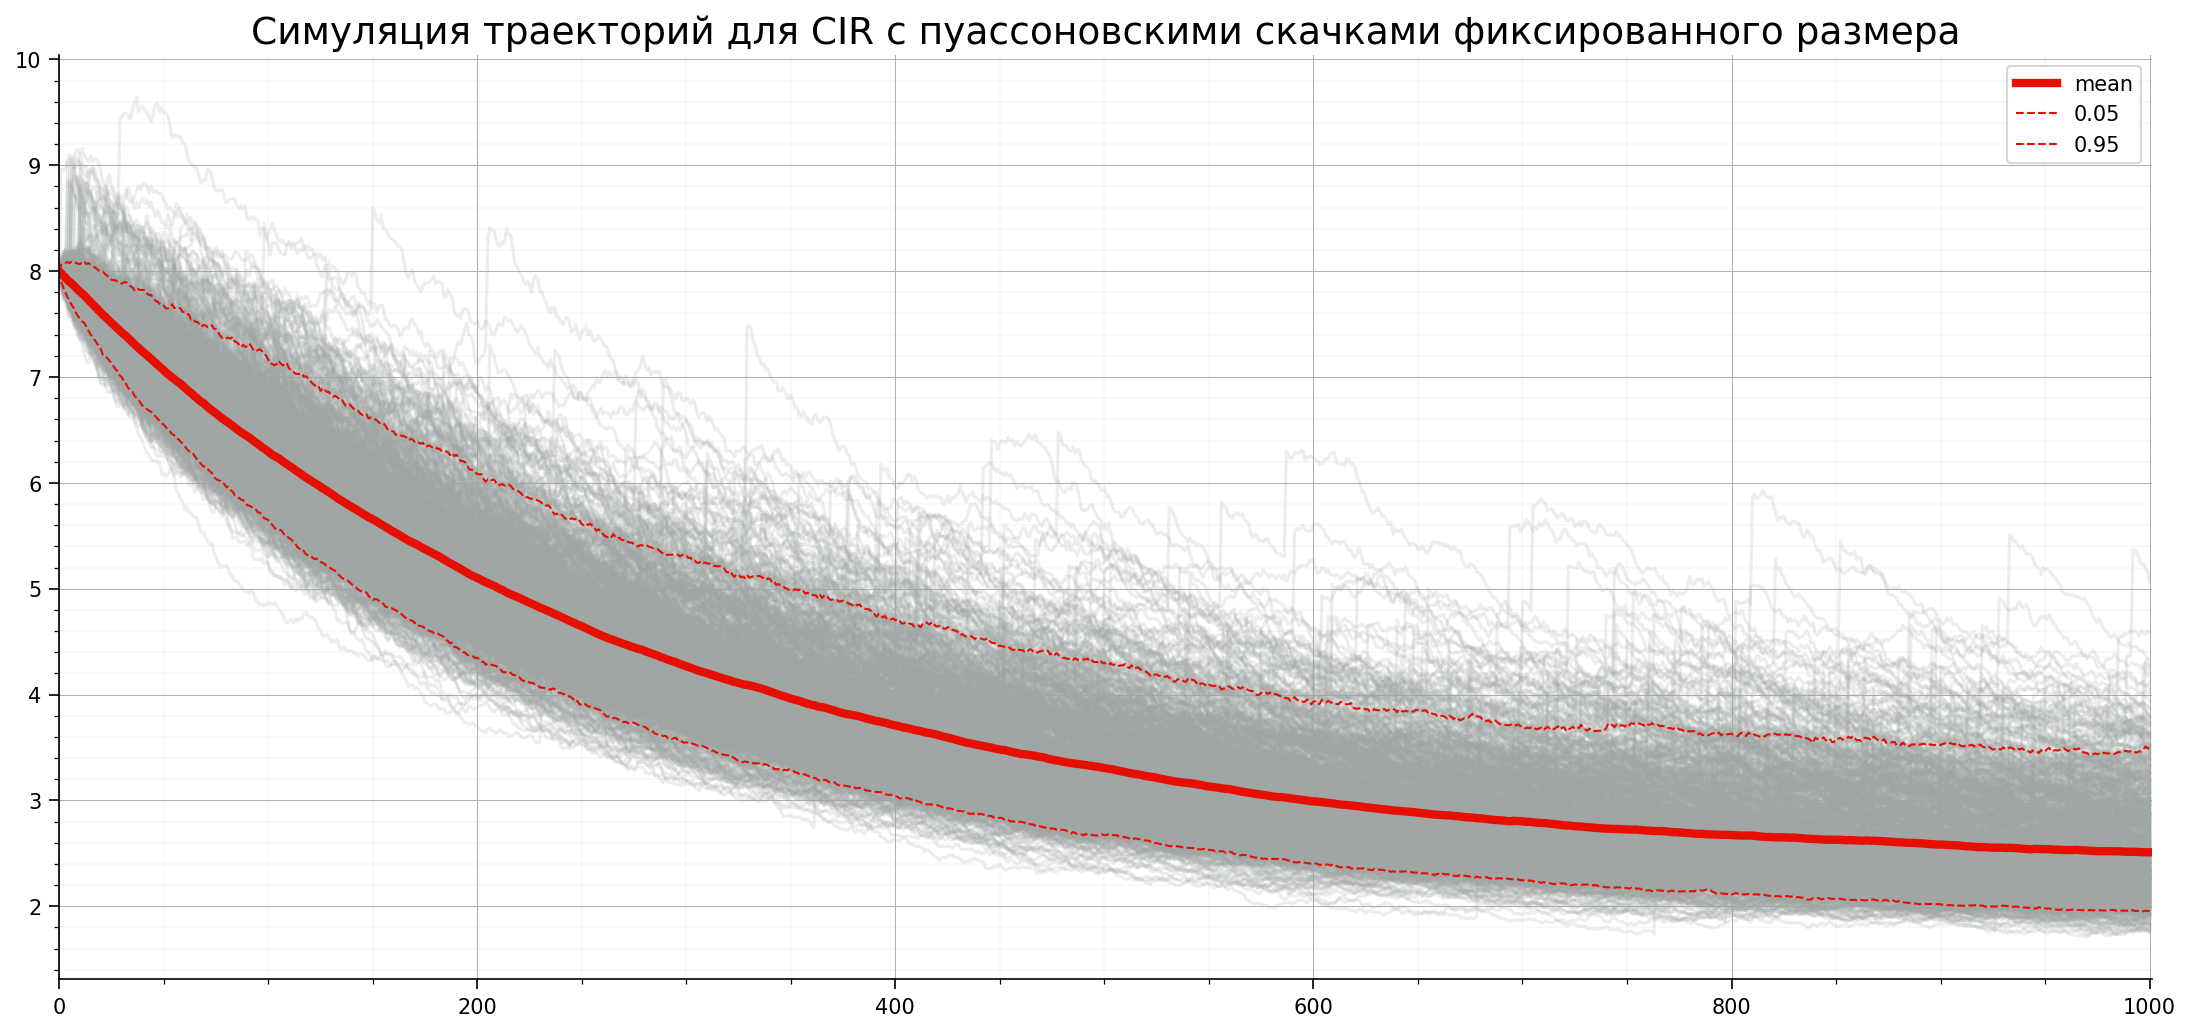

In [9]:
# Задаем какие-то параметры, которые нам нравятся (и которые мы хотим!)
alpha = 0.9
theta = 2
sigma = 0.1 # пошумим
lambda_jump = 0.3
jump_size = 1

n_steps = 1000 # 4 года
n_paths = 1000 # число путей для симуляции
dt = 1 / 252 # считаем, что в год у нас 252 дня идут торги, обоснование есть в блоке с rangeaccrual
r0 = 8 # начальное значение ставки

const_poisson = ConstPossionJumpsCIR(
    alpha=alpha, 
    theta=theta, 
    sigma=sigma,
    lambda_jump=lambda_jump,
    jump_size=jump_size,
)
const_poisson_paths = const_poisson.get_simulated_paths(
    n_steps=n_steps, n_paths=n_paths, dt=dt, r0=r0
)
ax = const_poisson.plot_paths(const_poisson_paths)
ax.set_title('Симуляция траекторий для CIR с пуассоновскими скачками фиксированного размера', fontsize=18)
plt.show()

## Ставка по RUB с помощью CIR и прыжков размера, распределенного нормально

CIR модель c Пуассоновскими прыжками нормально распределенного размера задается как:

$dr_t = \alpha(\theta - r_t)dt + \sigma \sqrt{r_t}dW_t + JdN_t$

где $\alpha$ - скорость возврата к среднему $\theta$, $\sigma$ - волатильность и мера, отвечающая за величину случайности, $J \sim N(jump\_mean, jump\_std)$ - размер Пуассоновского прыжка, $dN_t$ - интенсивность прыжков.

Использование схемы Эйлера-Муроямы позволяет получит следующее уравнение


$r_{t+dt} = r_t + \alpha(\theta - r_t)dt + \sigma \sqrt{r_t} (W_{t+dt} - W_{t}) + J(N_{t+dt} + N_t)$

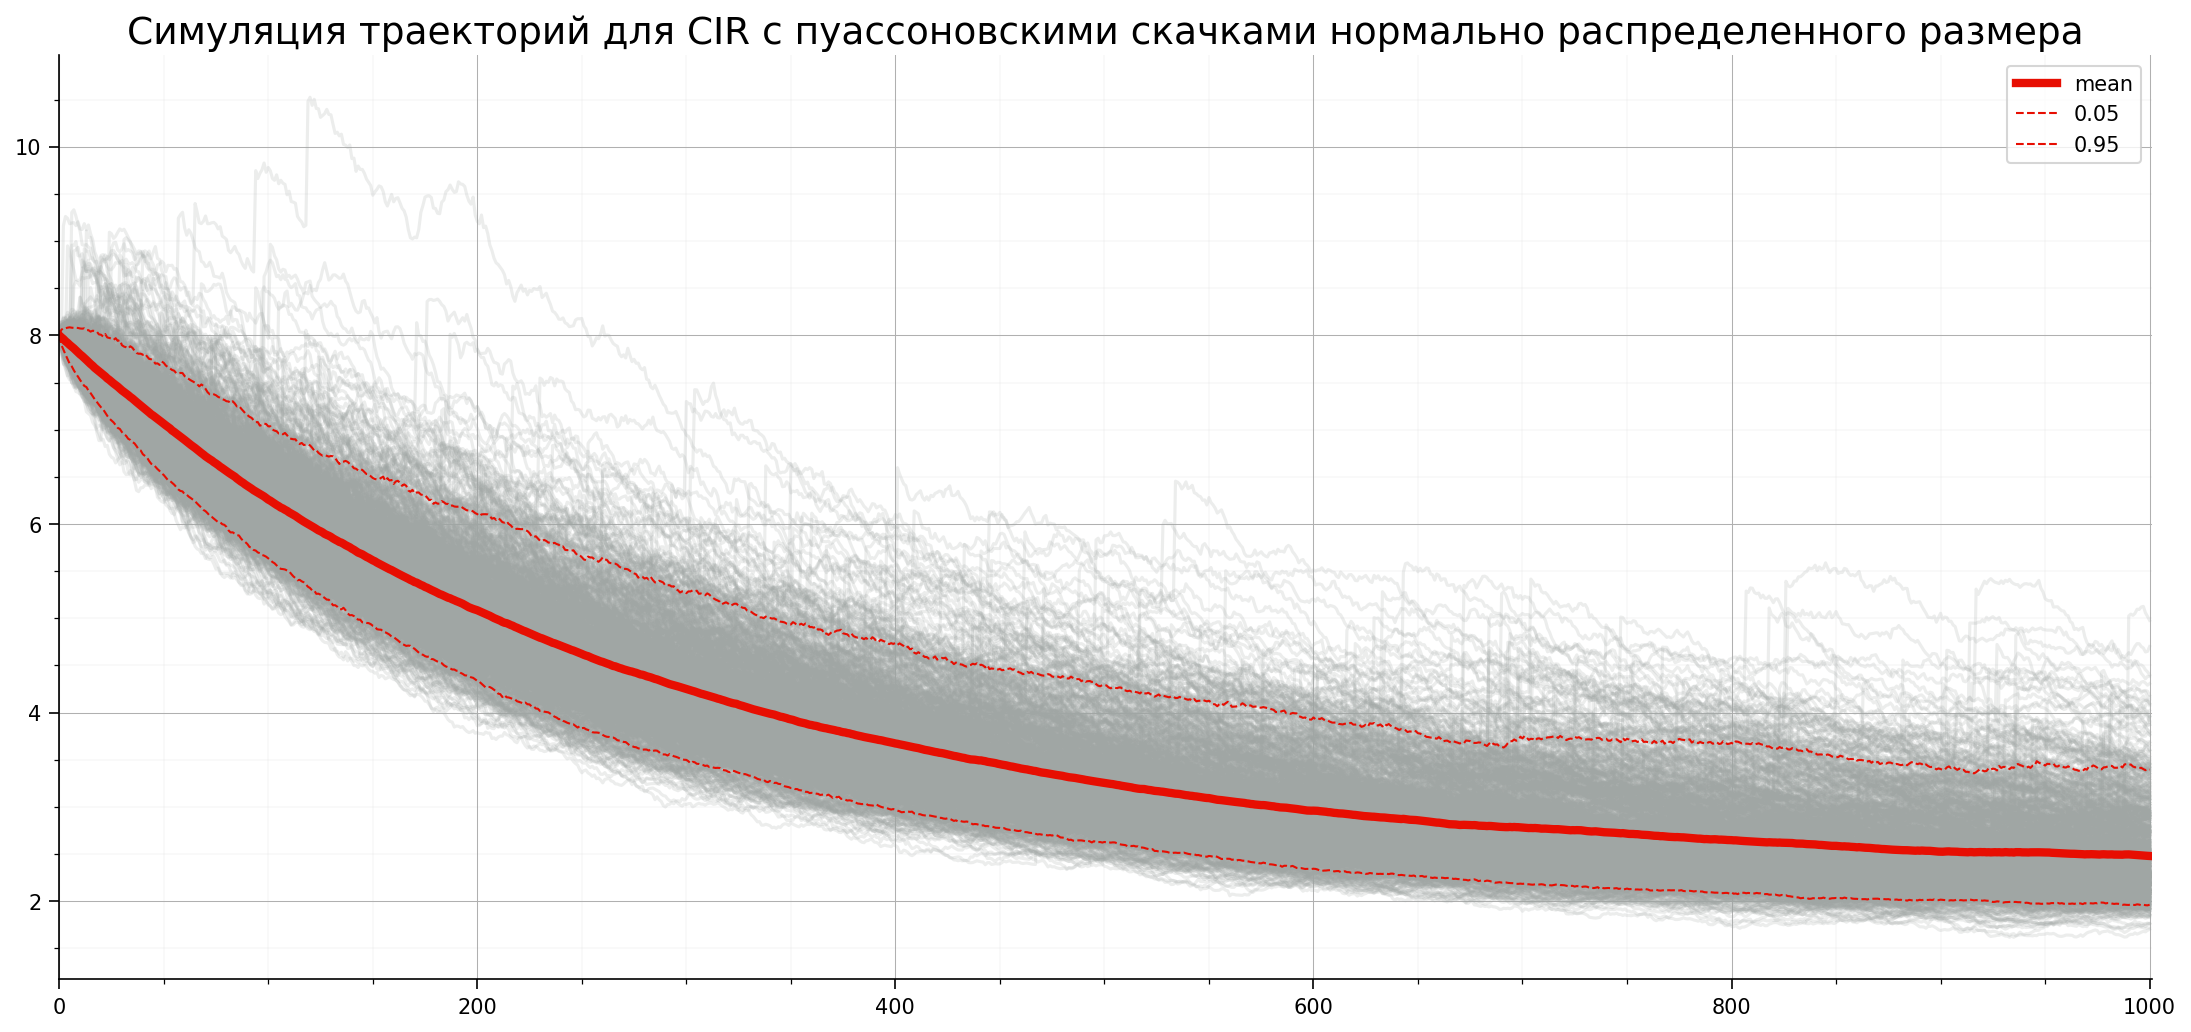

In [10]:
# Задаем какие-то параметры, которые нам нравятся (и которые мы хотим!)
alpha = 0.9
theta = 2
sigma = 0.1 # пошумим
lambda_jump = 0.3
jump_mean = 1
jump_std = 0.25

n_steps = 1000 # 4 года
n_paths = 1000 # число путей для симуляции
dt = 1 / 252 # считаем, что в год у нас 252 дня идут торги, обоснование есть в блоке с rangeaccrual
r0 = 8 # начальное значение ставки

normal_poisson = NormalPossionJumpsCIR(
    alpha=alpha, 
    theta=theta, 
    sigma=sigma,
    lambda_jump=lambda_jump,
    jump_mean=jump_mean,
    jump_std=jump_std,
)
normal_poisson_paths = normal_poisson.get_simulated_paths(
    n_steps=n_steps, n_paths=n_paths, dt=dt, r0=r0
)
ax = normal_poisson.plot_paths(normal_poisson_paths)
ax.set_title('Симуляция траекторий для CIR с пуассоновскими скачками нормально распределенного размера', fontsize=18)
plt.show()

# Оценка гиперпараметров для моделей

In [11]:
from simulation import (
    OLSCIRParamsEstimator,
    ConstPoissonParamsEstimator,
    FXsigmaParamsEstimator,
)

Для оценки параметров рассматриваются следующие подходы:

### CIR

$$r_{t+dt} = r_t + \alpha(\theta - r_t)dt + \sigma \sqrt{r_t} (W_{t+dt} - W_{t})$$

Учтем, что $W_{t+dt} - W_{t} \sim N(0, dt) = dt N(0, 1)$
и перегруппируем слагаемые:

$$\frac{r_{t+dt} - r_t}{\sqrt{r_t}} = \frac{\alpha \theta dt}{\sqrt{r_t}} - \alpha \sqrt{r_t}dt + \sigma \sqrt{dt} N(0, 1)$$

Тогда рассмотрим уравнение, полученное из рассматриваемого заменой переменных: 
$$y_t = \beta_1 z_{1t} + \beta_2 z_{2t} + \epsilon_t$$

$\beta_1 = \alpha \theta, z_{1t} = \frac{dt}{\sqrt{r_t}}, \beta_2 = -\alpha, z_{2t} = \sqrt{r_t}dt, \epsilon_t = \sigma \sqrt{dt} N(0, 1)$

Оценивая уравнение для $y_t$ с помощью OLS получаем оценки $\hat{\beta_1}$ и $\hat{\beta_2}$, из которых

$$\hat{\alpha} = -\hat{\beta_2}, \hat{\theta} = \frac{\hat{\beta_1}}{\hat{\alpha}}, \sigma = \frac{\hat{std(\epsilon)}}{\sqrt{dt}}$$

Уравнение выше используется для оценки гиперпараметров для CIR на основе исторических данных

In [12]:
r_usd_history = data[data.index <= pd.Timestamp('2021-12-10')]['usd_rate'].to_numpy()
OLSCIRParamsEstimator.get_estimation(
    r_usd_history, dt=1/252
)

{'alpha': 1.4919060131528745,
 'theta': 0.19846543278004766,
 'sigma': 1.6147615763667116}

## CIR + Constant Poisson jumps

$$dr_t = \alpha(\theta - r_t)dt + \sigma \sqrt{r_t}dW_t + JdN_t$$

Для оценки $J$ и $\lambda_{jump}$ (интенсивность $N_t$) для модели выше использовался подход с определением экстремально больших по модулю изменений ставки за dt на промежутке с кризисными периодами (с 01.10.2014 по 01.10.2015). `Экстремально большими` считались изменения, модуль которых выше, чем 0.9-квантиль. Для оценки размера скачка использовалось среднее по этим значениям. Таким образом:
$\lambda_{jump} \approx \frac{0.1}{dt}$ - интенсивность пуассоновских скачков, оцененная по взятому квантилю, $jump\_size = mean(\{change_i: change_i > q_{0.9}(all\_changes)\})$

In [13]:
repo_history = repo['rub_repo_rate'].to_numpy()
ConstPoissonParamsEstimator.get_estimation(
    repo_history, dt=1/252, quantile=0.9
)

{'jump_size': 0.8563999999999998, 'lambda_jump': 25.30120481927711}

## FX

$$\frac{dFX_t}{FX_t} = (r_t^{f} - r_t^{d})dt + \sigma dW_t$$

Для оценки $\sigma$ в модели выше все слагаемые были перенесены влево, таким образом, что:

$$\frac{FX_{t+dt} - FX_t}{FX_t} - (r_t^f - r_t^d)dt = \sigma \sqrt{dt} N(0, 1)$$

Итого получается, что наилучшее предсказание для $y_t$, равного части, стоящей слева, это среднее этого значения. Далее можно рассчитать $$\hat{\sigma} = \frac{std(\epsilon)}{dt}$$

In [14]:
r_rub_history = data[data.index <= pd.Timestamp('2021-12-10')]['rub_rate'].to_numpy()
fx_history = data[data.index <= pd.Timestamp('2021-12-10')]['fx'].to_numpy()
FXsigmaParamsEstimator.get_estimation(
    r_dom_history=r_rub_history,
    r_for_history=r_usd_history,
    fx_history=fx_history,
    dt=1/252
)

{'sigma': 0.12591956710979246}

# Range Accrual

**Модель для курса валюты**

$$\frac{dFX_t}{FX_t} = (r_t^{f} - r_t^{d})dt + \sigma dW_t,$$
где $r^f$ - `foreign rate`, $r^d$ - `domestic rate`, $\sigma$ - волатильность, а $dW_t$ - скоррелированная (через оцененную корреляцию приращений между историческими $r^f$, $r^d$ и $FX$) с стохастическими частями $r^f$ и $r^d$  случайность.

По схеме Эйлера-Муроямы можно преобразовать к

$$X_{t+dt}  = X_t[(r_t^{f} - r_t^{d})dt + \sigma (W_{t+dt} - W_{t}) + 1]$$

Далее в модуле ниже релизован расчет справедливой цены для RangeAccrual в несколько этапов:
1. Устанавливаются входные параметры.
2. Оцениваются параметры для CIR, CIR + poisson jumps, FX на исторических данных.
3. Генерируется скоррелированный шум для rub_rate, usd_rate, FX.
4. Симулируются траектории для ставок, после чего эти траектории передаются в модуль для симуляции FX.
5. Полученные `n_paths` траекторий по `n_steps` шагов каждая используются для прайсинга цены RangeAccrual:
    - В каждый день из `n_steps` оценивается вероятность того, что цена не выйдет за границы `lower_bound` и `upper_bound` как доля значений траекторий, у которых цена в текущий день лежит в диапазоне.
    - Полученные `n_steps` вероятностей умножаются на выплату по RangeAccrual в сутки (мат. ожидание потерь банка от данного инструмента), после чего суммируются.
    - Полученное число - ожидаемые потери банка по RangeAccrual, поэтому `fair value` = `notional` - `ожидаемые потери`


**Обоснование выбора шага**

Для модели используется шаг $dt = \frac{1}{252}$ по 2 причинам: 1) мы рассматриваем RangeAccrual, который является бинарным опционом и действует по сути по суточно, благодаря чему сутки - подходящий период и 2) Считаем, что в году 252 торговых дня (в интернете есть разные цифры, но вроде как на NYSE считается, что 252 дня идут торги в год)

In [15]:
from simulation import (
    BaselineRangeAccrualPricingStrategy,
)

Текущая справедливая стоимость: 615.75 при номинале 1000


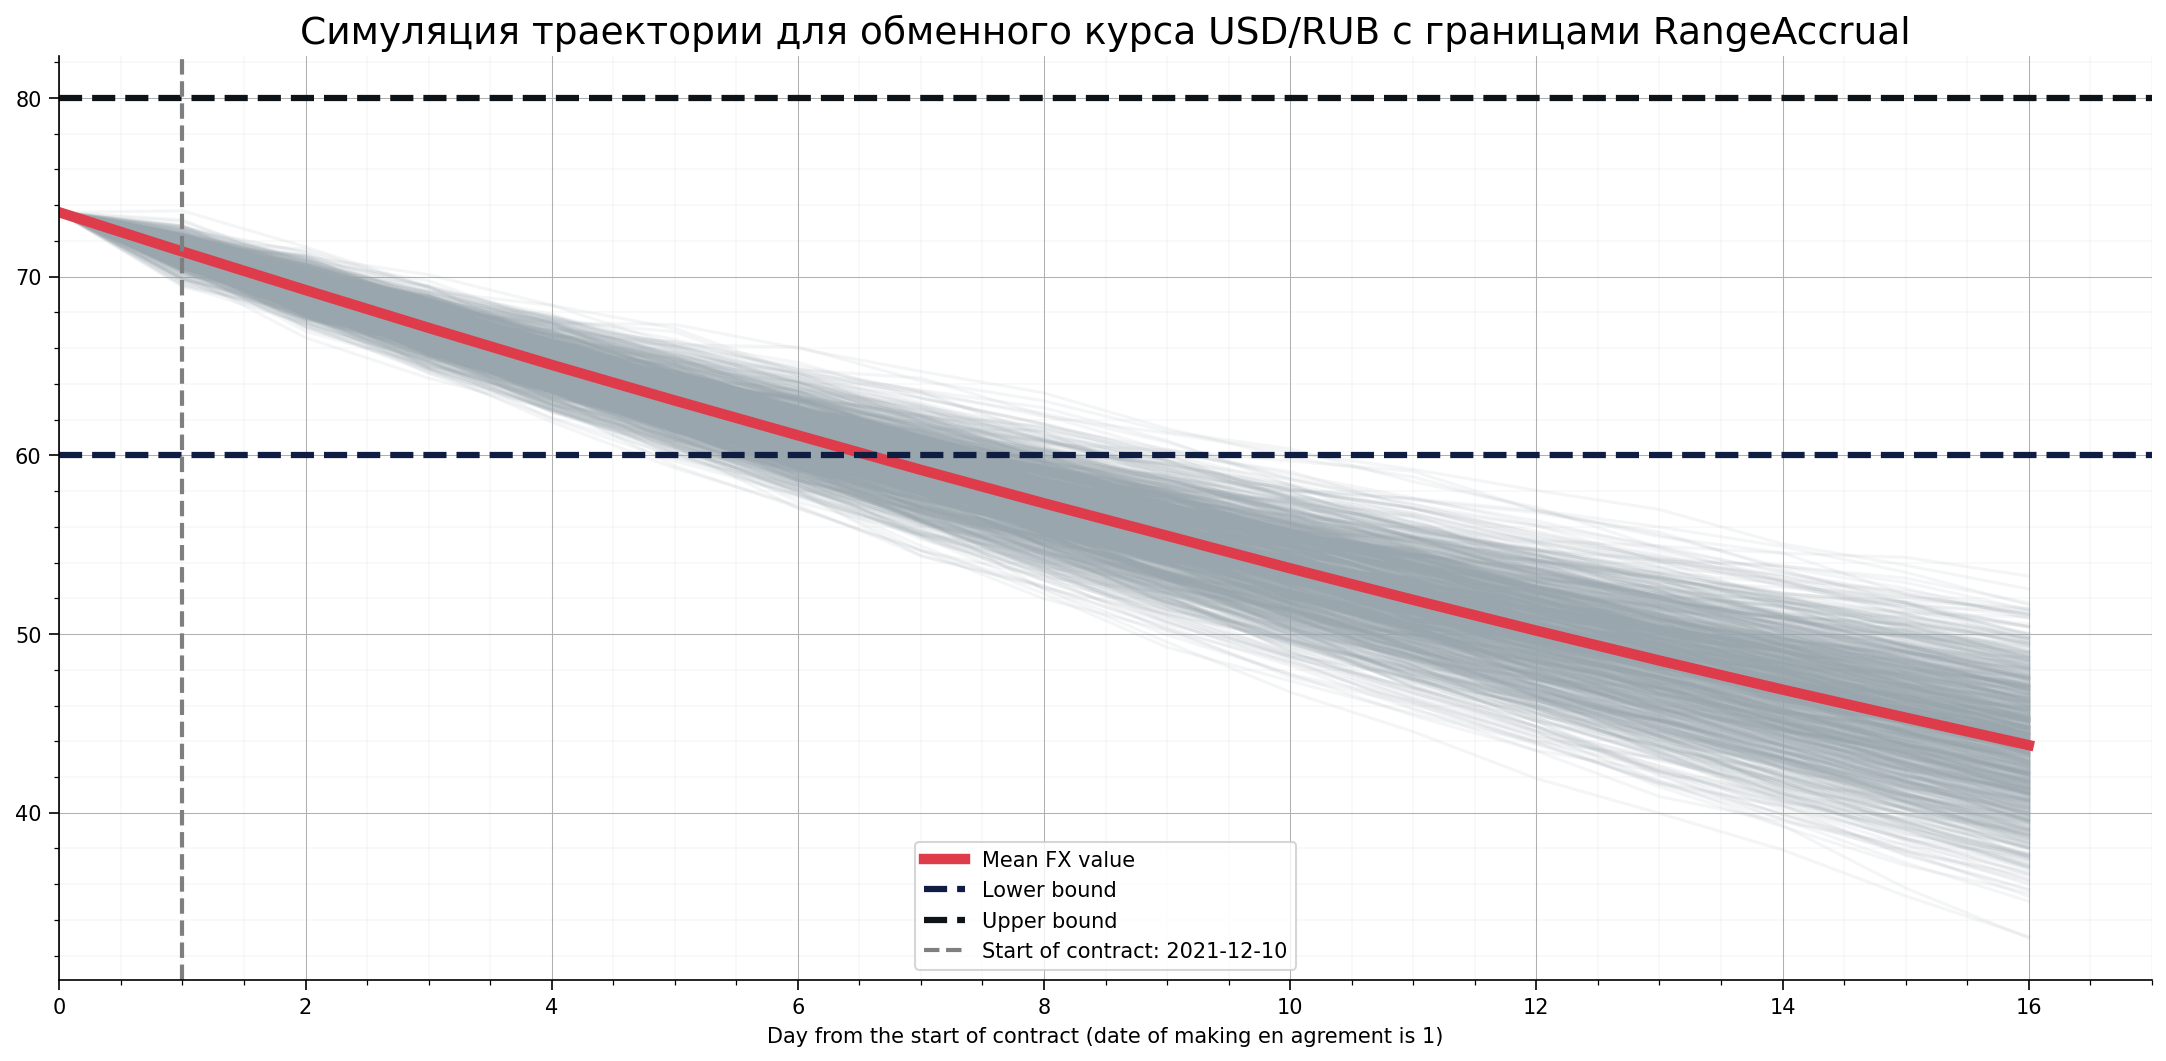

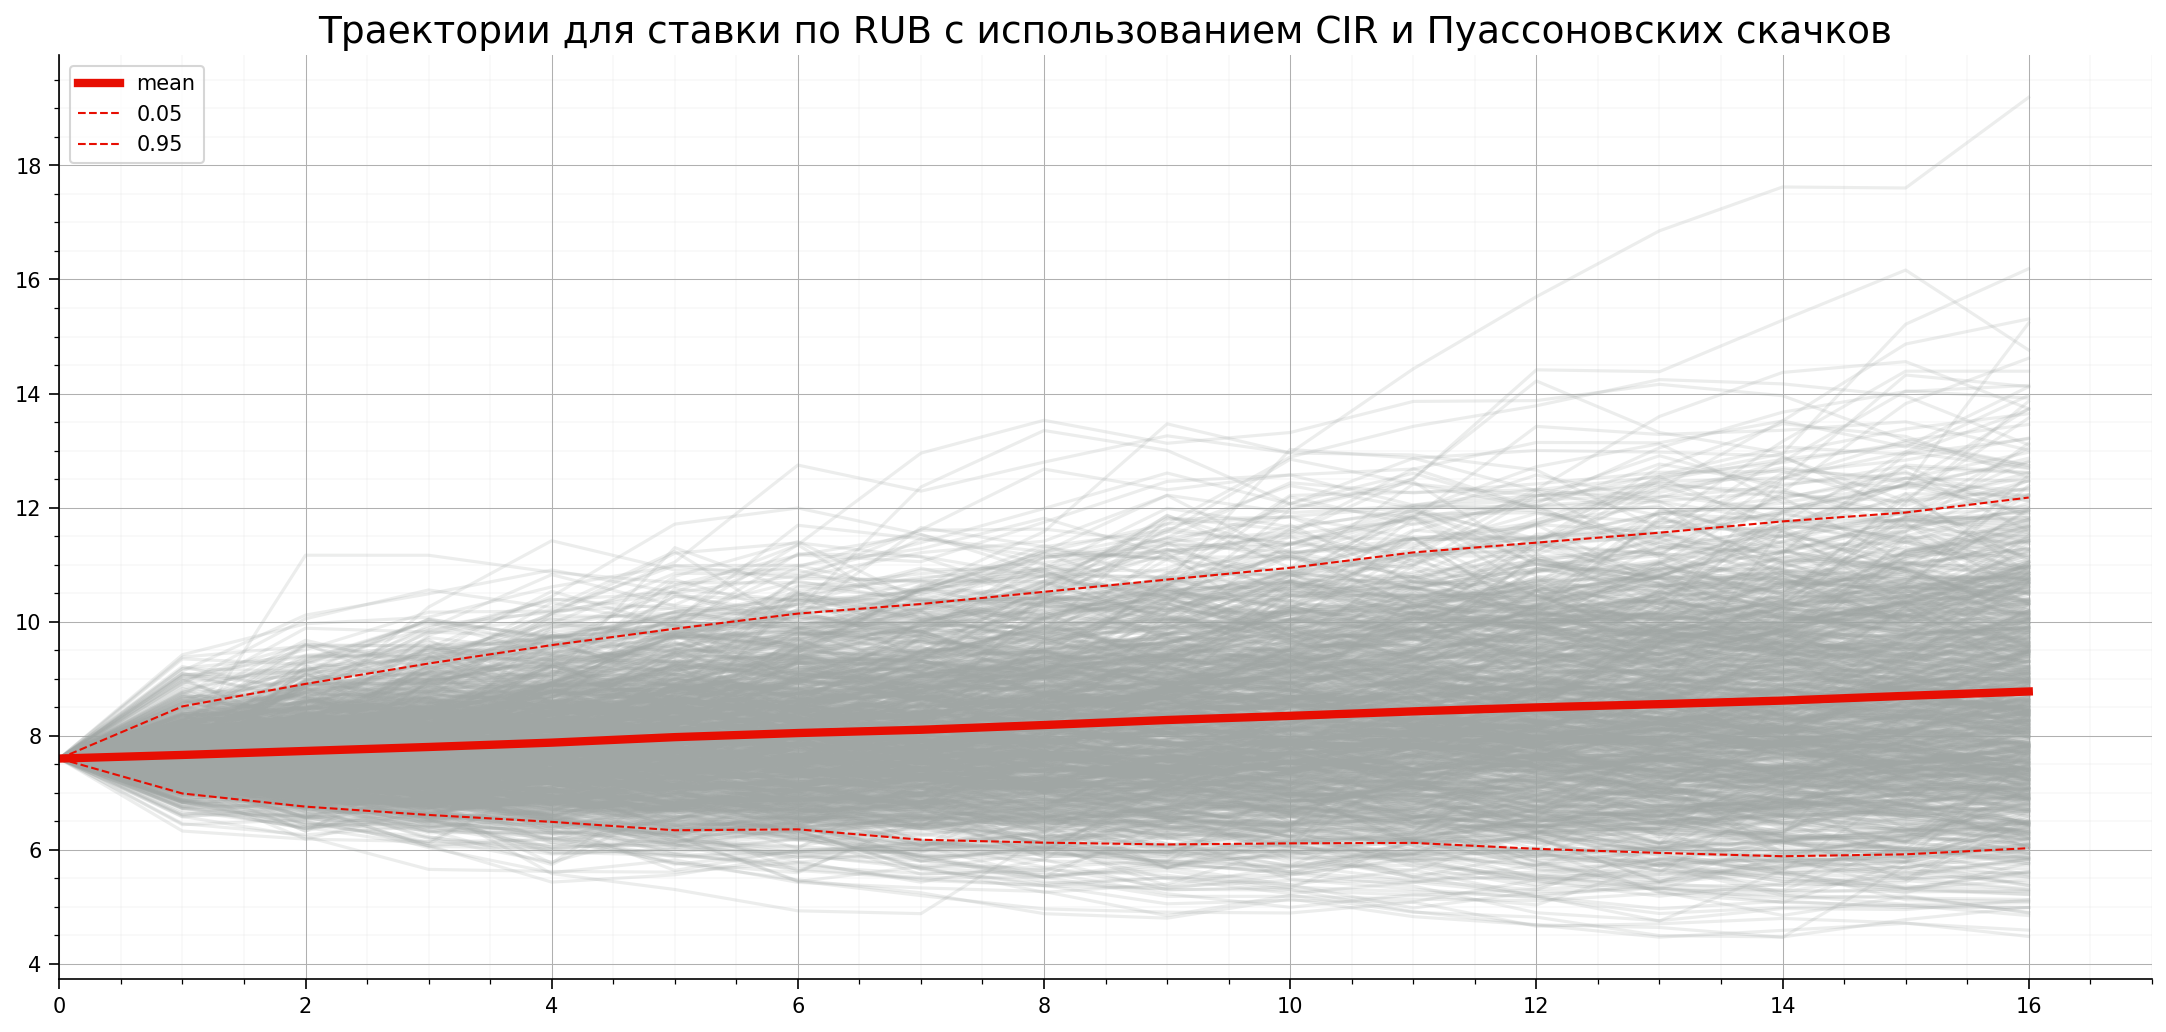

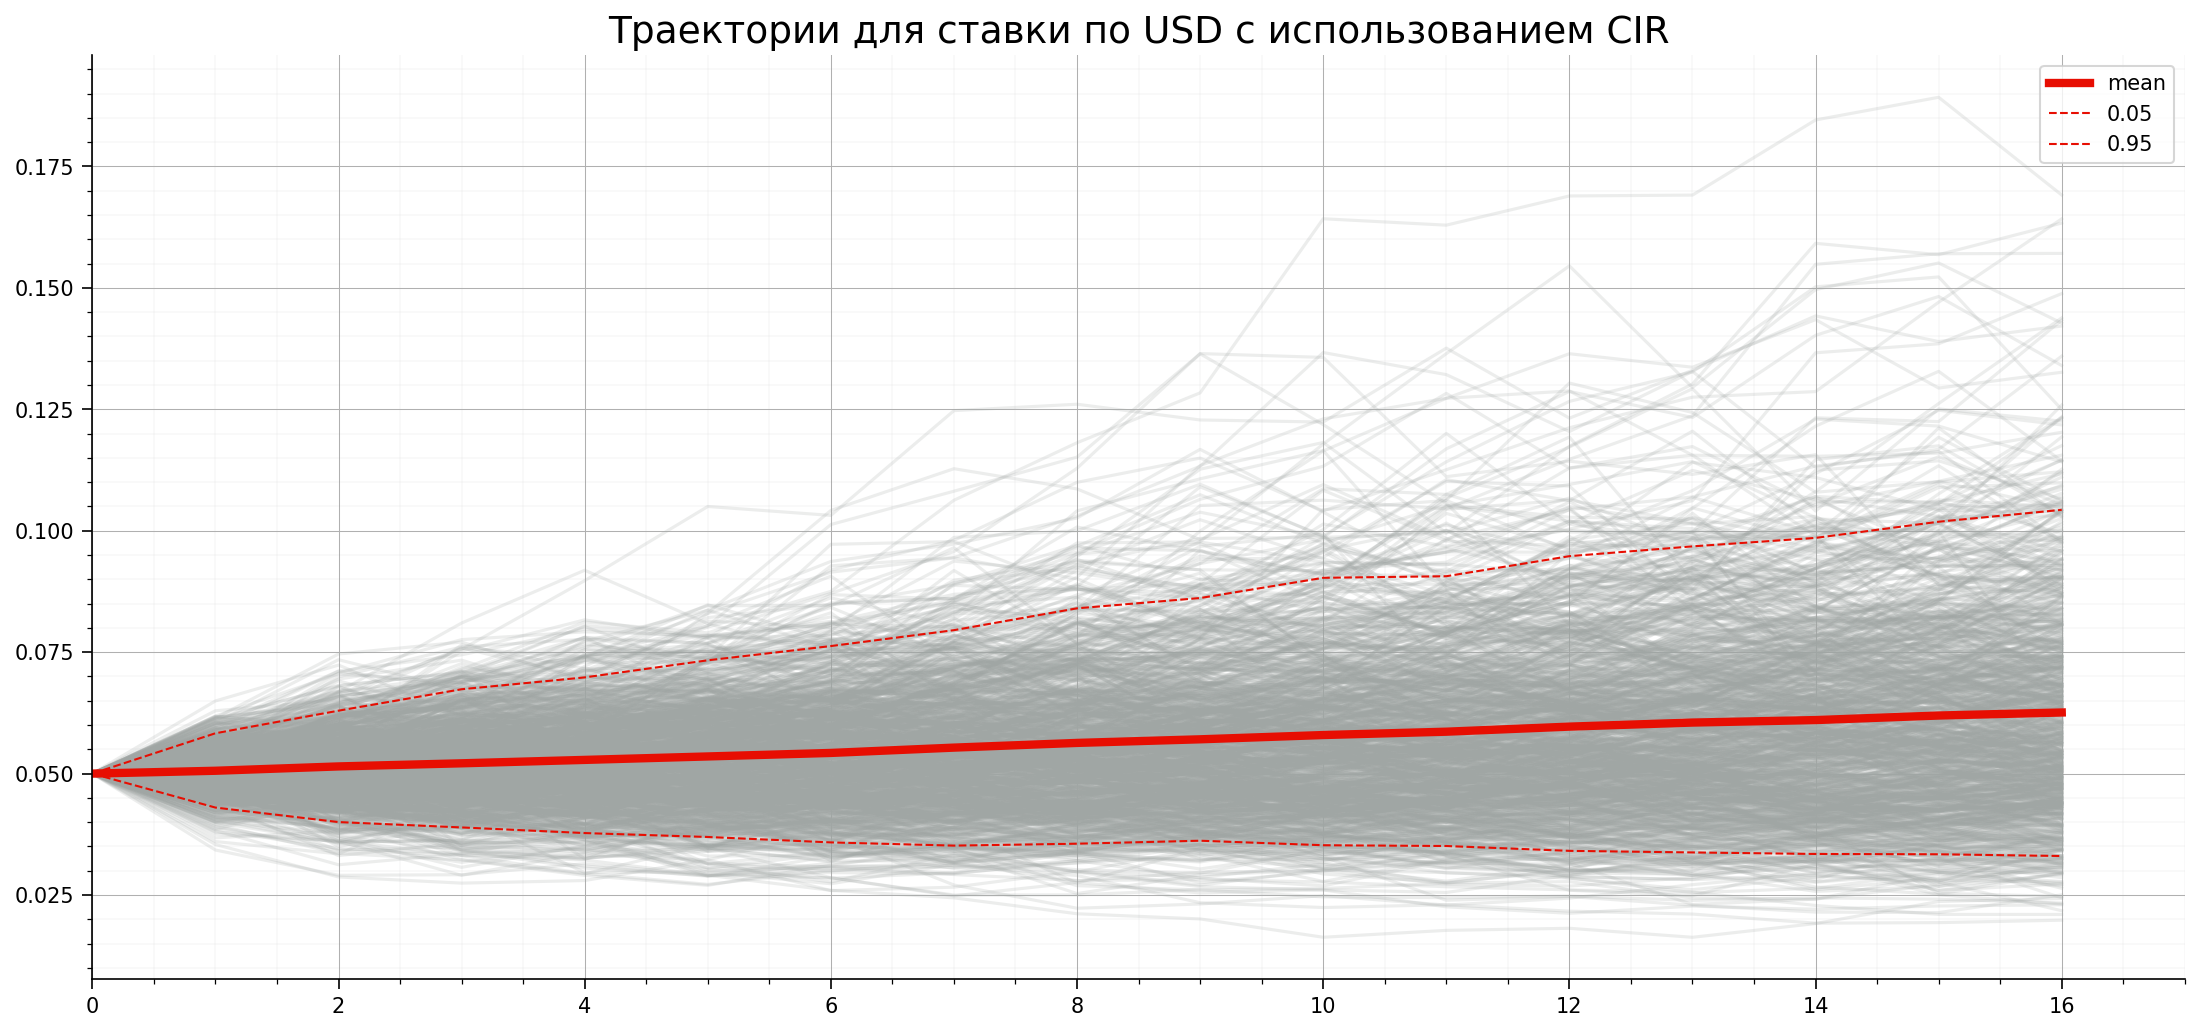

In [16]:
# Конфиг для Range accrual
ra_config = {
    'contract_start': '2021-12-10',
    'contract_end': '2021-12-31',
    'upper_bound': 80,
    'lower_bound': 60,
    'notional': 1000,
}
# Ограничим историю до даты заключения контракта
cur_history = data[
    (data.index < pd.Timestamp(ra_config['contract_start']))
].copy()
r_dom_history = cur_history['rub_rate'].to_numpy()
r_for_history = cur_history['usd_rate'].to_numpy()
fx_history = cur_history['fx'].to_numpy()

# Конфиг для параметров симуляции
simulation_config = {
    # Исторические данные
    'r_dom_history': r_dom_history,
    'r_for_history': r_for_history,
    'fx_history': fx_history,
    'r_dom_crysis_history': repo['rub_repo_rate'].to_numpy(),
    # Количество путей
    'n_paths': 1000,
    'dt': 1/252,
    # 'n_steps': 30, # Если не указать явно, будет рассчитано как число рабочих дней
}
ra_model = BaselineRangeAccrualPricingStrategy(
    simulation_config=simulation_config,
    ra_config=ra_config
)
# Справедливая стоимость
fair_value = ra_model.get_simulation_results()
ax = ra_model.plot_range_w_paths()
print(f'Текущая справедливая стоимость: {round(fair_value, 3)} при номинале {ra_config["notional"]}')
ax.set_title('Симуляция траектории для обменного курса USD/RUB с границами RangeAccrual', fontsize=18)
plt.show()
ax = ra_model.r_dom_model.plot_paths(ra_model.r_dom)
ax.set_title('Траектории для ставки по RUB с использованием CIR и Пуассоновских скачков', fontsize=18)
plt.show()
ax = ra_model.r_for_model.plot_paths(ra_model.r_for)
ax.set_title('Траектории для ставки по USD с использованием CIR', fontsize=18)
plt.show()

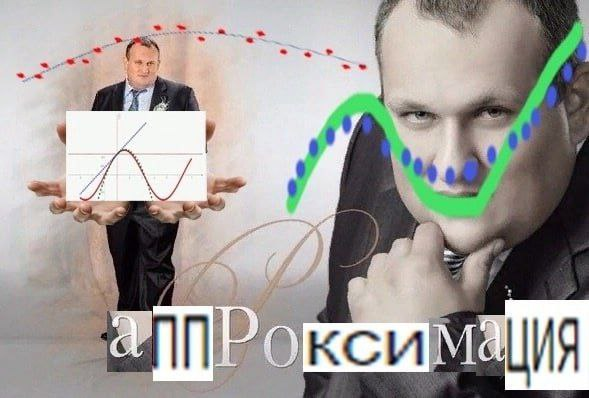

In [17]:
Image('pictures/approximation.jpg')

In [18]:
print('Оцененные по историческим данным параметры для моделей')
for key, val in ra_model.model_params.items():
    print(key)
    print(val)
    print()

Оцененные по историческим данным параметры для моделей
poisson_const_params
{'jump_size': 0.8563999999999998, 'lambda_jump': 25.30120481927711}

cir_dom_params
{'alpha': 1.0747555674006644, 'theta': 5.866520377706203, 'sigma': 0.7749851773476155}

cir_for_params
{'alpha': 1.4918963970857215, 'theta': 0.1986550934174178, 'sigma': 1.6158151283680662}

fx_params
{'sigma': 0.1259917815933778}

